In [3]:
!pip install xgboost optuna

     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 210 kB 50.3 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 146 kB 67.4 MB/s 
     |████████████████████████████████| 112 kB 66.7 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=dab8744f06735e0f56d022db8fbf748ec1a7805c27743b775f52de57ac262575
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [14]:
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


def objective(trial, df, y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1e5),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e2),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1e2),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1e2)
    }
    kf = StratifiedKFold(n_splits=3, random_state=15, shuffle=True)

    y_hats = []
    y_tests = []

    for train_index, test_index in kf.split(df, y):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_hats += model.predict(X_test).tolist()
        y_tests += y_test.tolist()

    return f1_score(y_tests, y_hats)

X = pd.read_csv("features24h.csv").drop(['pool_address', 'token_address'], axis=1)
X, y = X.drop("label", axis=1), X['label']

ids, total_probs, total_targets = [], [], []
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
for fold, (t, v) in enumerate(skfolds.split(X, y)):
    X_train, X_test = X.iloc[t], X.iloc[v]
    y_train, y_test = y.iloc[t], y.iloc[v]

    func = lambda trial: objective(trial, X_train.copy(), y_train.copy())
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials=100)

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    preds_scorings = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    sensibilitat = recall_score(y_test, preds)
    precisio = precision_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)

    print("{},{},{},{},{}".format(accuracy, sensibilitat, precisio, f1, fold))
    ids += X_test.index.tolist()
    total_probs += preds.tolist()
    total_targets += y_test.tolist()

final_df = pd.DataFrame({'ids': ids, 'Pred': total_probs, 'Label': total_targets}).to_csv("scorings_24h_XGBoost.csv", index=False)

[I 2022-05-16 21:50:42,590] A new study created in memory with name: no-name-43a89515-2a44-42e2-a771-687627fe1e32
[I 2022-05-16 21:50:42,648] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 7, 'min_child_weight': 10279.464934238054, 'subsample': 0.8934338649245293, 'learning_rate': 0.7785955701620562, 'gamma': 3.8553320465816805, 'lambda': 7.225637091305175e-08, 'alpha': 0.0010790397663795422}. Best is trial 0 with value: 0.0.
[I 2022-05-16 21:50:42,705] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 9, 'min_child_weight': 4781.5326442152855, 'subsample': 0.9176539657129326, 'learning_rate': 0.41129011959586387, 'gamma': 3.2913422340595874e-05, 'lambda': 0.014939520062656511, 'alpha': 0.007350989498165031}. Best is trial 0 with value: 0.0.
[I 2022-05-16 21:50:43,033] Trial 2 finished with value: 0.7826086956521738 and parameters: {'max_depth': 9, 'min_child_weight': 0.10748263073619513, 'subsample': 0.9914513757101644, 'learning_rate': 0.46295788197293786

0.8646616541353384,0.8333333333333334,0.8620689655172413,0.847457627118644,0


[I 2022-05-16 21:51:04,119] Trial 2 finished with value: 0.814004376367615 and parameters: {'max_depth': 4, 'min_child_weight': 0.02071860296500402, 'subsample': 0.7554382472224055, 'learning_rate': 0.04961222406318068, 'gamma': 0.00018781127762243515, 'lambda': 1.2802667419193792e-08, 'alpha': 7.466223305573383}. Best is trial 2 with value: 0.814004376367615.
[I 2022-05-16 21:51:04,181] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_child_weight': 1892.7808871823206, 'subsample': 0.5954697754547877, 'learning_rate': 0.7324820071052391, 'gamma': 8.028453985673808e-07, 'lambda': 0.08894057772495963, 'alpha': 2.659455100238292e-08}. Best is trial 2 with value: 0.814004376367615.
[I 2022-05-16 21:51:04,367] Trial 4 finished with value: 0.8051391862955032 and parameters: {'max_depth': 5, 'min_child_weight': 1.0077732068770436e-08, 'subsample': 0.5551382493335502, 'learning_rate': 0.39960959348374764, 'gamma': 9.737304808669766, 'lambda': 1.4425334108725172e-06, 'alp

0.8421052631578947,0.7377049180327869,0.9,0.8108108108108109,1


[I 2022-05-16 21:51:19,624] Trial 1 finished with value: 0.7924528301886792 and parameters: {'max_depth': 7, 'min_child_weight': 7.194411616574357e-08, 'subsample': 0.9489118767504228, 'learning_rate': 0.7487736469380422, 'gamma': 0.3536095675278447, 'lambda': 0.000199981953472379, 'alpha': 9.826200680273743e-07}. Best is trial 1 with value: 0.7924528301886792.
[I 2022-05-16 21:51:19,687] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 10, 'min_child_weight': 316.9479372046879, 'subsample': 0.5178169164483775, 'learning_rate': 0.17456482293590753, 'gamma': 0.1512795290926604, 'lambda': 0.0012309225409842203, 'alpha': 2.2645574843155903e-06}. Best is trial 1 with value: 0.7924528301886792.
[I 2022-05-16 21:51:19,822] Trial 3 finished with value: 0.7991360691144709 and parameters: {'max_depth': 6, 'min_child_weight': 0.9959399773397121, 'subsample': 0.734526304825725, 'learning_rate': 0.8577386667254534, 'gamma': 1.1465891227675606e-06, 'lambda': 4.3862273383169763e-08, 'a

0.7969924812030075,0.7049180327868853,0.8269230769230769,0.7610619469026548,2


[I 2022-05-16 21:51:36,245] Trial 1 finished with value: 0.8 and parameters: {'max_depth': 9, 'min_child_weight': 0.04707246517800047, 'subsample': 0.5414407990164499, 'learning_rate': 0.049789202199389246, 'gamma': 1.772760969283054e-05, 'lambda': 1.4414592895782583, 'alpha': 8.072526909710948e-08}. Best is trial 0 with value: 0.800865800865801.
[I 2022-05-16 21:51:36,398] Trial 2 finished with value: 0.7074235807860261 and parameters: {'max_depth': 4, 'min_child_weight': 2.92994741768459e-08, 'subsample': 0.9193328712039949, 'learning_rate': 0.7751919519383678, 'gamma': 79.99861247402936, 'lambda': 0.0009921023235633757, 'alpha': 91.64536970694544}. Best is trial 0 with value: 0.800865800865801.
[I 2022-05-16 21:51:36,497] Trial 3 finished with value: 0.8200836820083681 and parameters: {'max_depth': 4, 'min_child_weight': 13.999862688312563, 'subsample': 0.8671497712754603, 'learning_rate': 0.1401049649615952, 'gamma': 0.022886755232153503, 'lambda': 0.017152526342656352, 'alpha': 0.

0.8863636363636364,0.8666666666666667,0.8813559322033898,0.8739495798319329,3


[I 2022-05-16 21:52:03,734] Trial 2 finished with value: 0.7898089171974523 and parameters: {'max_depth': 4, 'min_child_weight': 1.0266564840492247e-07, 'subsample': 0.931804762044435, 'learning_rate': 0.8338516411639609, 'gamma': 0.21489051282185748, 'lambda': 0.0017727472680897942, 'alpha': 0.15467328065113412}. Best is trial 1 with value: 0.8025751072961373.
[I 2022-05-16 21:52:03,983] Trial 3 finished with value: 0.8043956043956044 and parameters: {'max_depth': 8, 'min_child_weight': 3.9388674551970256e-08, 'subsample': 0.8448994267121552, 'learning_rate': 0.21591852772499345, 'gamma': 59.019175675027824, 'lambda': 1.2876505823808876e-05, 'alpha': 1.0087654878174058e-05}. Best is trial 3 with value: 0.8043956043956044.
[I 2022-05-16 21:52:04,227] Trial 4 finished with value: 0.7974137931034483 and parameters: {'max_depth': 7, 'min_child_weight': 5.606624737020777e-07, 'subsample': 0.5631075729590529, 'learning_rate': 0.26190531154293367, 'gamma': 0.0005639407100947636, 'lambda': 0.

0.7954545454545454,0.7833333333333333,0.7704918032786885,0.7768595041322314,4


In [10]:
model

XGBClassifier()

In [15]:
!pip install shap
import shap
shap_values = shap.TreeExplainer(model).shap_values(X)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

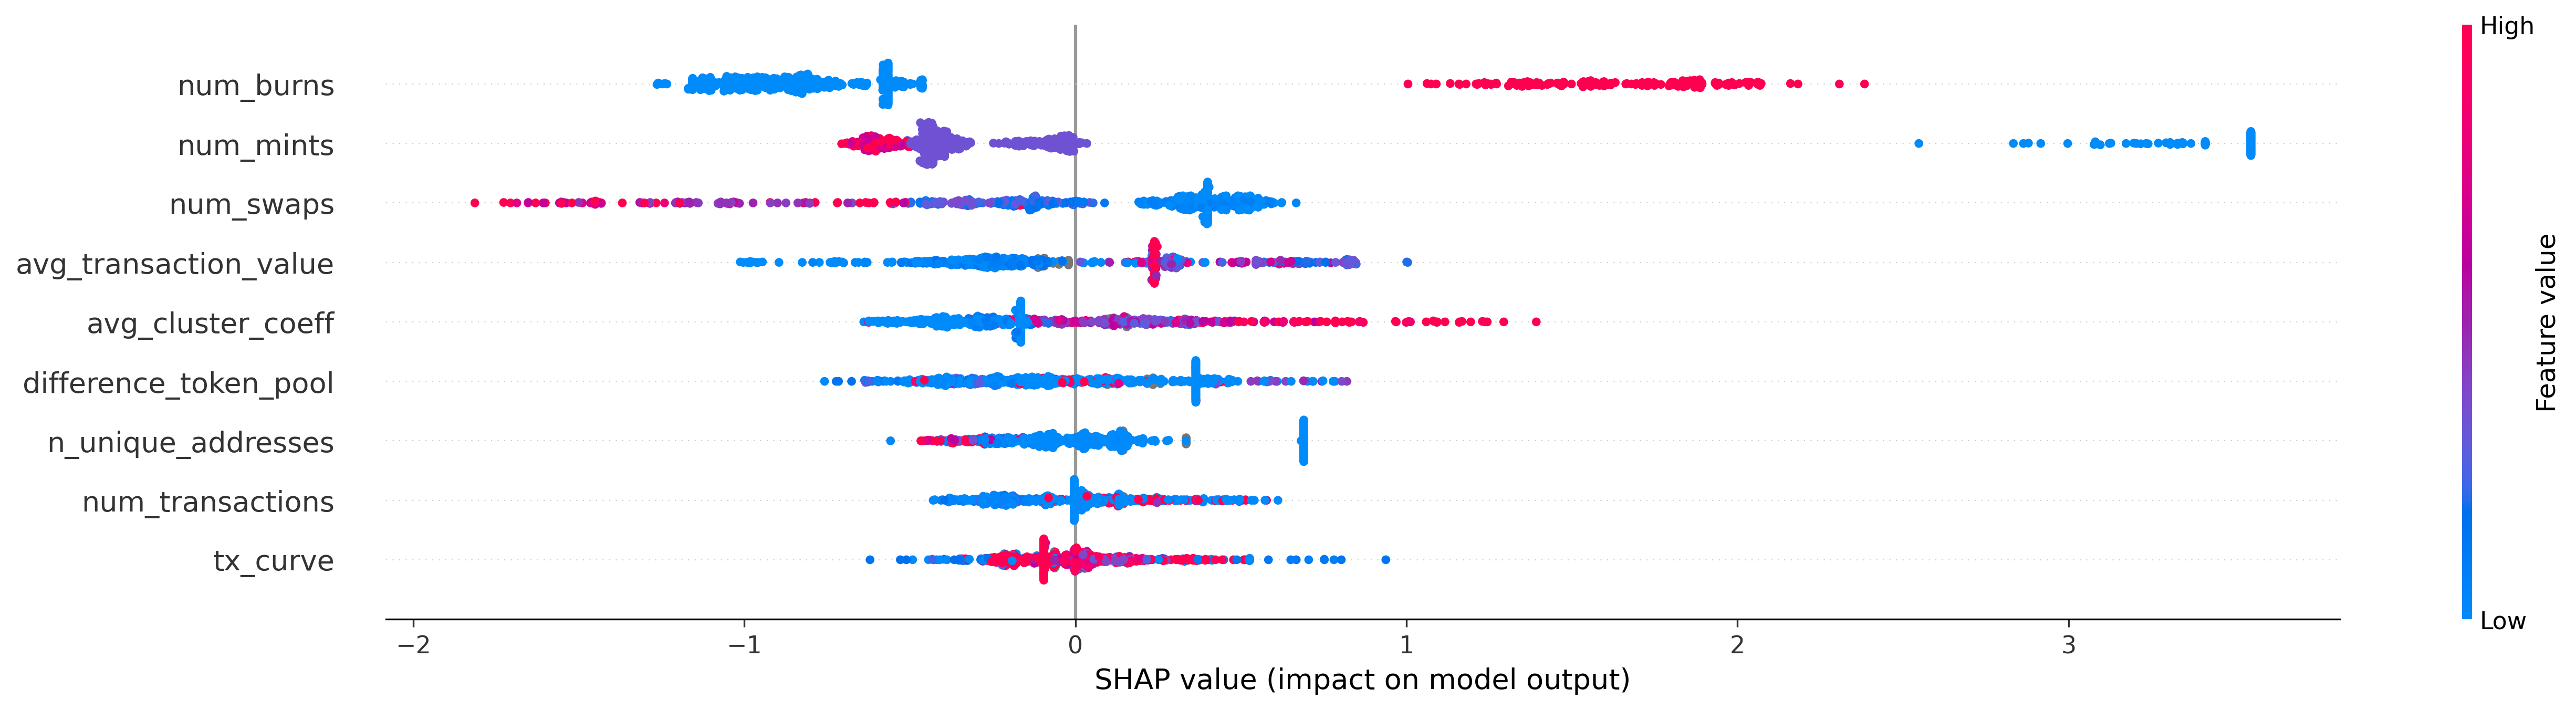

In [16]:
shap.summary_plot(shap_values, X, plot_size = (20, 5))

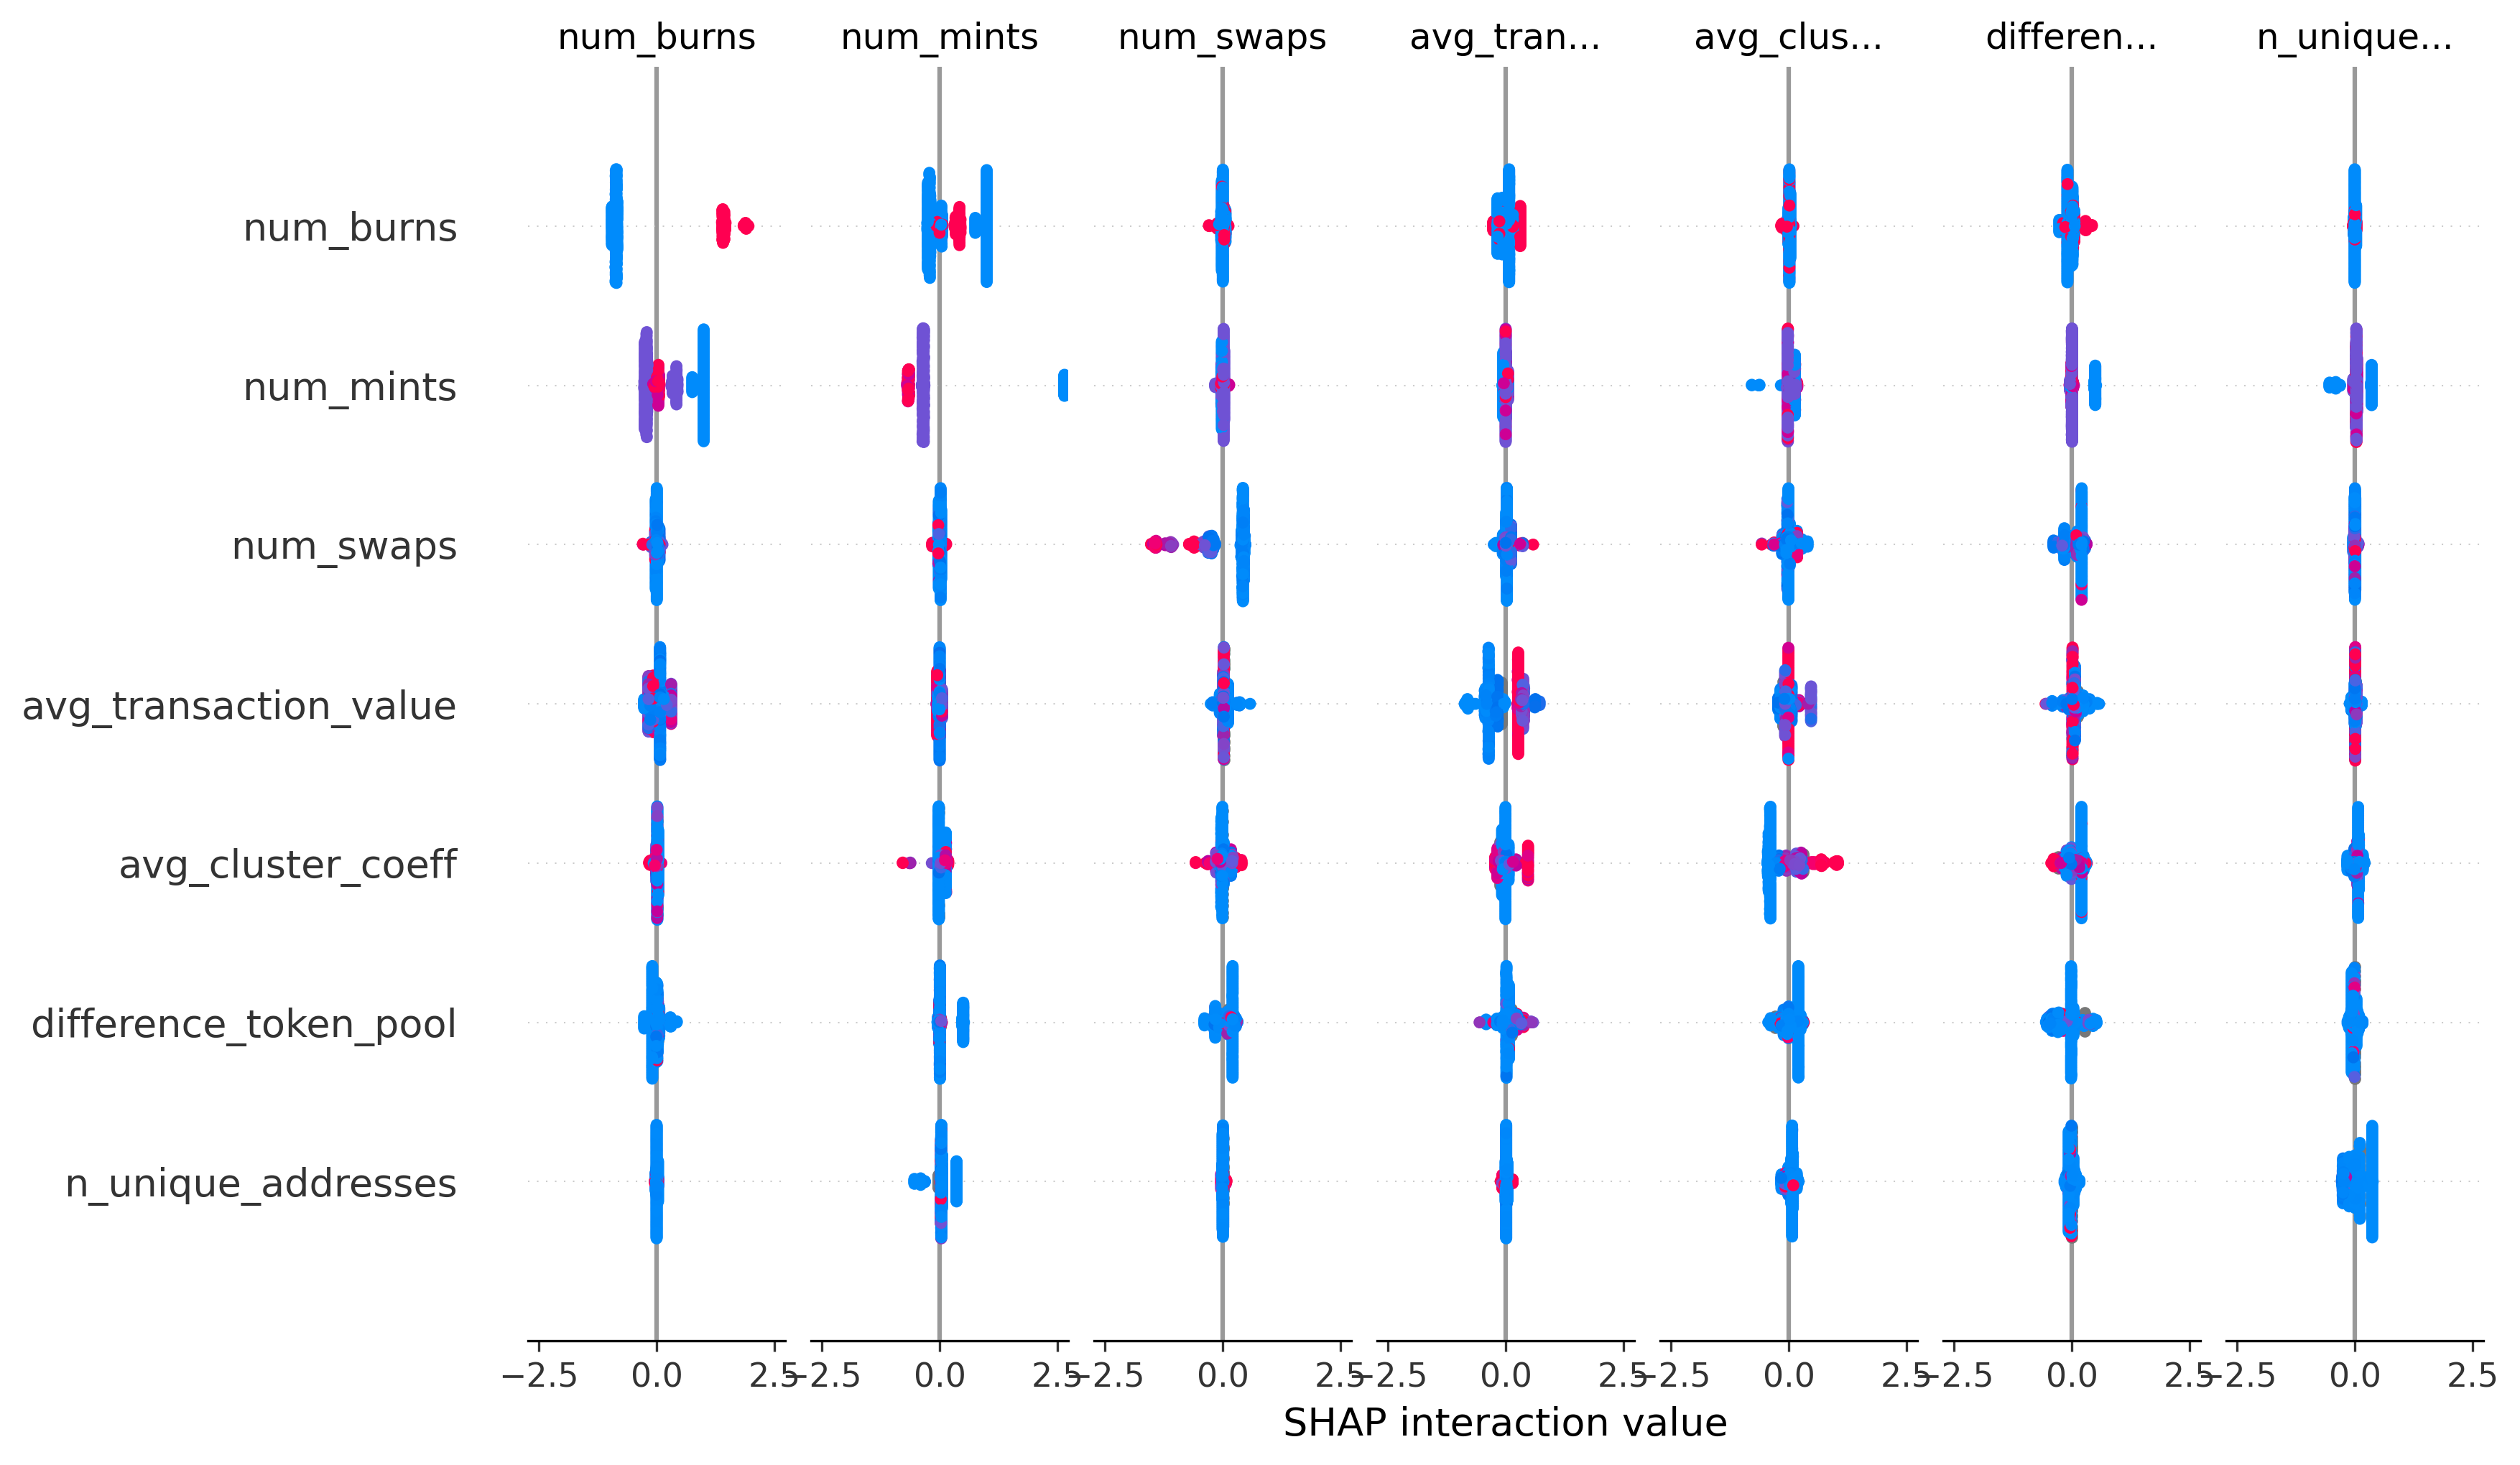

In [17]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)